In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=0, num_effect_modifiers=2,
                                    treatment_is_binary=False)
df=data['df']
df.head()

,X0,X1,W0,W1,W2,W3,v,y
0,-0.305479,-1.424311,0.902971,-0.410261,1.327639,-0.276382,7.818735,80.953605
1,0.540621,0.066608,0.798266,-0.544229,0.708848,-0.087960,4.542594,51.239417
2,-1.435605,0.716829,-1.103412,-0.153828,0.117500,0.545991,-2.639553,-30.536938
3,0.438980,-2.279681,0.356339,0.103525,-0.369371,0.248482,1.363386,9.289820
4,1.289768,0.403345,0.210973,0.221565,-1.254937,1.571872,2.164994,26.303131


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting
/home/amit/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/amit/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


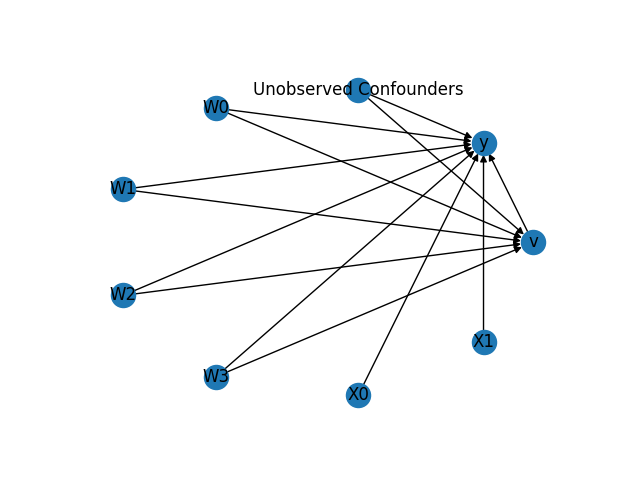

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W1', 'Unobserved Confounders', 'W0', 'W2', 'W3']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W1,W0,W2,W3))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W1,W0,W2,W3,U) = P(y|v,W1,W0,W2,W3)
### Estimand : 2
Estimand name: iv
No such variable found!



In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCate",
                                 target_units = df["X0"]>2, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W1+W0+W2+W3
/home/amit/.local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amit/.local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amit/.local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amit/.local/lib/python3.7/site-packages/sklearn/ensem

769
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W1,W0,W2,W3))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W1,W0,W2,W3,U) = P(y|v,W1,W0,W2,W3)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: y~v+W1+W0+W2+W3
## Estimate
Value: 10.831978841281648



/home/amit/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/amit/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/dist-packages/econml/dml.py:281: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  UserWarning)
/home/amit/.local/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarni

In [8]:
##Refuting the estimate

In [9]:
### Random 

In [10]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

AttributeError: 'EconmlCateEstimator' object has no attribute '_econml_methodname'